# Two component signals: constant amplitude and constant frequency
### Produces Figure 18

We consider simple linear combination of sine waves. We vary (1) the frequency ratio and (2) the amplitude ratio between the two components.

We aim to replicate:
- Rilling and Flandrin (2008), Figure 5.

Reference
- Rilling, G. and Flandrin, P. (2008). One or two frequencies? the empirical mode decomposition answers. IEEE Transactions on Signal Processing, 56(1):85–95.

**Note.** Rilling and Flandrin (2008) use the opposite convention as Daetig and Schlurmann (2004). Daetig and Schlurmann (2004) have a low frequency and the high frequency is multiples of it (from 1 to 15). Rilling and Flandrin (2008) have a high frequency and the low frequency is ratios of it (0.01 to 1.0). This results in the order of the components being reversed. Keep this in mind when looking at this notebook and $\texttt{5_emd_replicate_daetig.ipynb}$.

### Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import scipy.stats as stats
import sys
import time
import PyEMD

from scipy.io import loadmat
from scipy.signal import hilbert, chirp
from scipy import fftpack

### Set up and run simulation

In [2]:
""" 
===============================================================================================
                                    PARAMETER DEFINITIONS
===============================================================================================
"""
np.random.seed(1)                          # set seed for reproducibility

# FREQUENCIES OF COMPONENTS --------------------------------------------------------------
n_freq_steps = 50                          # number of frequency increments
min_freq_ratio = 0.01
max_freq_ratio = 1
f_r = np.linspace(start=min_freq_ratio, 
                  stop=max_freq_ratio, 
                  num=n_freq_steps)
f_1 = 1                                    # frequency of carrier wave, scalar (8 Hz theta)
f_2 = f_1 * f_r                            # frequency of riding wave, vector
F = []                                     # List to contain each increment
for k in range(n_freq_steps):              # build the list
    F.append([f_1, np.round(f_2[k], 2)])

# AMPLITUDES OF COMPONENTS --------------------------------------------------------------
n_amp_steps = 50                           # number of frequency increments
min_amp_ratio = -2                       
max_amp_ratio = 2
a_r = np.logspace(start=min_amp_ratio,
                  stop=max_amp_ratio, 
                  num=n_amp_steps)

a_1 = 1                                    # frequency of carrier wave, scalar (8 Hz theta)
a_2 = a_1 * a_r                            # frequency of riding wave, vector
A = []                                     # List to contain each increment
for k in range(n_amp_steps):               # build the list
    A.append([a_1, np.round(a_2[k], 5)])

    
# SAMPLE RATES ----------------------------------------------------------------------------
fs = 20*f_1                                # 20x the fastest riding wave

# SIGNAL LENGTHS --------------------------------------------------------------------------
cycle_length = 1/f_1                       # one cycle of slowest component
max_cycles = 30                            # max number of cycles
nS = max_cycles * cycle_length             # max length in seconds

# COMPONENT PARAMETERS --------------------------------------------------------------------
nF = len(F[0])                             # number of frequency components
p = np.random.uniform(low=0.0,             # phase offsets for components
                      high=2*np.pi,
                      size=nF)

# STORE RESULTS ---------------------------------------------------------------------------
# initialize matrix to store correlations
C_all = np.empty(shape=(n_freq_steps, n_amp_steps, nF, nF)) # correlations
E_all = np.empty(shape=(n_freq_steps, n_amp_steps))         # error measure from Rilling
IF_all = np.empty(shape=(n_freq_steps, n_amp_steps, nF))    # instantaneous frequency error
IA_all = np.empty(shape=(n_freq_steps, n_amp_steps, nF))    # instantaneous amplitude error
IF_nb_all = np.empty(shape=(n_freq_steps, n_amp_steps, nF)) # inst freq error, no boundary
IA_nb_all = np.empty(shape=(n_freq_steps, n_amp_steps, nF)) # inst amp error, no boundary
n_IMFs = np.empty(shape=(n_freq_steps, n_amp_steps))        # number of IMFs
n_time_points = np.empty(shape=(n_freq_steps, n_amp_steps)) # number of time points
n_pts_inst_f = np.empty(shape=(n_freq_steps, n_amp_steps))  
n_pts_inst_a = np.empty(shape=(n_freq_steps, n_amp_steps))
n_pts_inst_nb = np.empty(shape=(n_freq_steps, n_amp_steps))
    
""" 
===============================================================================================
                                      RUN SIMULATION
===============================================================================================
"""

# keep track of time
start_time = time.time()

for f_i, f in enumerate(F):
    for a_i, a in enumerate(A):
        t = np.arange(0, nS, 1/fs)              # time
        nT = len(t)                             # number of time steps
        noise_mean = 0.0                        # noise DC component
        noise_std = 0.0 * max_amp_ratio * a_1   # noise strength

        # -------------------------------------------------------------------------------
        # Build artificial signal
        # -------------------------------------------------------------------------------

        # define components, C
        C = np.ndarray(shape=(nF, nT))
        for i in range(nF):
            C[i, :] = a[i] * np.sin(2*np.pi*f[i]*t + p[i])

        # add noise
        noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(nT,))
        x = np.sum(C,0) + noise

        # -------------------------------------------------------------------------------
        # Empirical mode decomposition
        # -------------------------------------------------------------------------------
        emd = PyEMD.EMD()                       # make instance of EMD class
        emd.emd(x)                              # call emd on the data
        imfs, res = emd.get_imfs_and_residue()  # extract intrinsic mode funcs, residual
        imfs = imfs[0:nF, :]                    # select only the first nF imfs
        nIMF = imfs.shape[0]                    # counts number of imfs

        # -------------------------------------------------------------------------------
        # Hilbert Transform
        # -------------------------------------------------------------------------------
        # compute: instantaneous amplitude, phase, frequency
        # note:    use fftpack to pad signal for speed improvement
        analytic_signal = hilbert(imfs, 
                                  fftpack.next_fast_len(np.shape(imfs)[1]))[:len(imfs)]
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = (np.diff(instantaneous_phase) /
                                   (2.0*np.pi) * fs)

        # -------------------------------------------------------------------------------
        # Compare imfs to original components
        # -------------------------------------------------------------------------------
        # Correlation
        Cx = np.zeros((nIMF, nF)) # preallocate correlation matrix
        for i in range(nIMF):
            for j in range(nF):
                Cx[i,j] = np.corrcoef(imfs[i,:], C[j,:])[0,1] # compute correlation
                
        # measure from: Rilling and Flandrin (2008)
        E_rf = np.sqrt(np.sum(np.abs(imfs[0,:] - C[0,:])**2)) / np.sqrt(np.sum(np.abs(C[1,:])**2))

        # Compare instantaneous freq and amplitude
        if np.size(amplitude_envelope, axis=0) == nF:
            n_pts_f = np.size(instantaneous_frequency, axis=1)
            n_pts_a = np.size(amplitude_envelope, axis=1)

            # with boundaries
            inst_f = [np.sum(np.abs(instantaneous_frequency[0,:] - f[0]))/n_pts_f,
                      np.sum(np.abs(instantaneous_frequency[1,:] - f[1]))/n_pts_f]

            inst_a = [np.sum(np.abs(amplitude_envelope[0,:] - a[0]))/n_pts_a,
                      np.sum(np.abs(amplitude_envelope[1,:] - a[1]))/n_pts_a]

            # without boundaries
            start = int(n_pts_f/15)
            stop = int(n_pts_f - n_pts_f/15)
            n_pts_nb = stop - start
            inst_f_nb = [np.sum(np.abs(instantaneous_frequency[0,start:stop] - f[0]))/n_pts_nb,
                         np.sum(np.abs(instantaneous_frequency[1,start:stop] - f[1]))/n_pts_nb]

            inst_a_nb = [np.sum(np.abs(amplitude_envelope[0,start:stop] - a[0]))/n_pts_nb,
                         np.sum(np.abs(amplitude_envelope[1,start:stop] - a[1]))/n_pts_nb]
        else:

            n_pts_f = -1
            n_pts_a = -1
            n_pts_nb = -1

            inst_f = [10**10, 10**10]
            inst_a = [10**10, 10**10]
            inst_f_nb = [10**10, 10**10]
            inst_a_nb = [10**10, 10**10]

        # -------------------------------------------------------------------------------
        # Store stuff
        # -------------------------------------------------------------------------------  
        C_all[f_i, a_i, :, :] = Cx           # correlation
        E_all[f_i, a_i] = E_rf               # measure from: Rilling and Flandrin (2008)
        IF_all[f_i, a_i, :] = inst_f         # instantaneous frequency error
        IA_all[f_i, a_i, :] = inst_a         # instantaneous amplitude error
        IF_nb_all[f_i, a_i, :] = inst_f_nb   # instantaneous frequency error, no boundary
        IA_nb_all[f_i, a_i, :] = inst_a_nb   # instantaneous amplitude error, no boundary

        n_IMFs[f_i, a_i] = nIMF
        n_time_points[f_i, a_i] = nT
        n_pts_inst_f[f_i, a_i] = n_pts_f
        n_pts_inst_a[f_i, a_i] = n_pts_a
        n_pts_inst_nb[f_i, a_i] = n_pts_nb

        # -------------------------------------------------------------------------------
        # Print progress
        # -------------------------------------------------------------------------------
        elapsed_time = time.time() - start_time # get current time
        print('\r', end='')
        print('\r', 'f: ' + str(f_i+1) + '/' + str(n_freq_steps) +
                  ', a: ' + str(a_i+1) + '/' + str(n_amp_steps) + 
              ', Time: ' + str(np.round(elapsed_time,2)), end='')

/Users/Andrew/anaconda/lib/python3.5/site-packages/scipy/signal/signaltools.py:1616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  h = h[ind]


 f: 50/50, a: 50/50, Time: 36.72

### Phase offsets

In [143]:
from fractions import Fraction

c_p0 = Fraction(p[0] / np.pi).limit_denominator(max_denominator=10)
c_p1 = Fraction(p[1] / np.pi).limit_denominator(max_denominator=10)

print(str(c_p0) + ', ' + str(c_p1))

5/6, 13/9


### Check number of IMFs
Notice at boundaries where the method breaks down there are at times only one IMF.

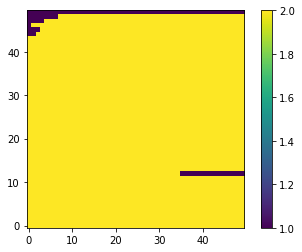

In [3]:
plt.imshow(n_IMFs, origin='lower')
plt.colorbar()
plt.show()

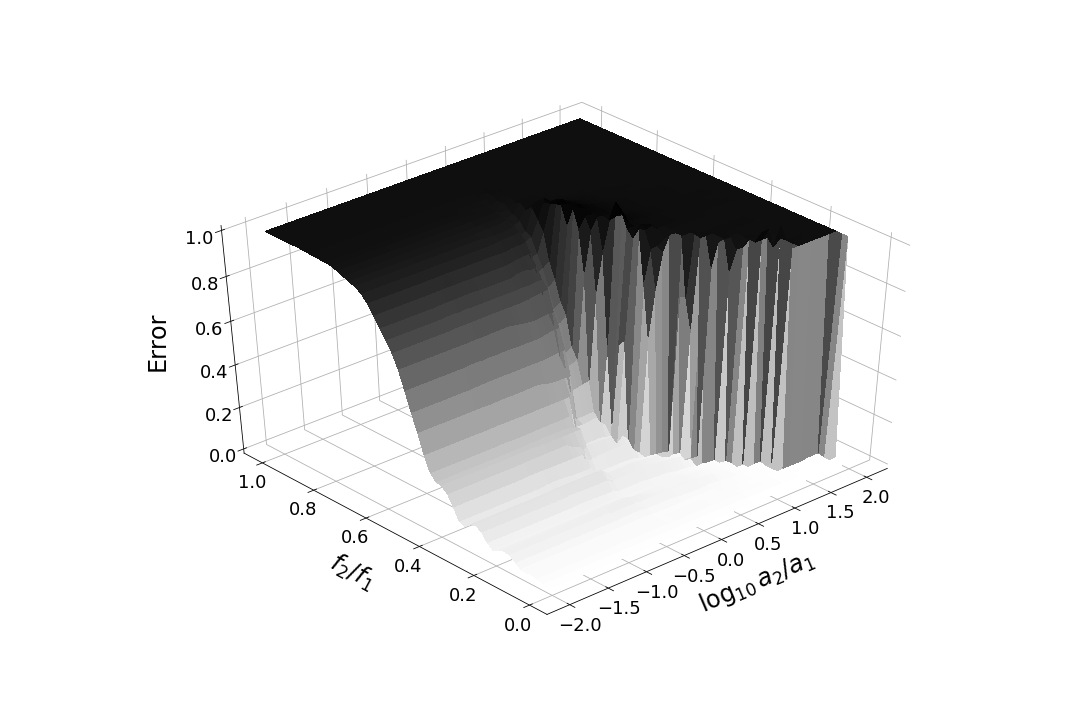

In [141]:
# change display option to show proper size
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# figure
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

# define data
X = np.log10(a_r)
Y = f_r
X, Y = np.meshgrid(X, Y)
Z = E_all

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='gray_r', edgecolor='none',
                       linewidth=0, antialiased=False)

ax.view_init(azim=-132, elev=42)

# Customize the z axis.
ax.set_zlim(0, 1.0)

# define labels
ax.set_xlabel('$\log_{10} \, a_2/a_1$', fontsize=24)
ax.set_ylabel('$f_2/f_1$', fontsize=24)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('Error', fontsize=24, rotation=90)

# tick sizes
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
ax.zaxis.set_tick_params(labelsize=18)

# spacing between label and ticks
ax.xaxis.labelpad=20
ax.yaxis.labelpad=20
ax.zaxis.labelpad=20

ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# save figure
plt.savefig('plots/ch4-1-3_surface_plot_amp_freq.pdf', bbox_inches = "tight")

plt.show()

### Replicate Figure 5 from Rilling and Flandrin (2008)

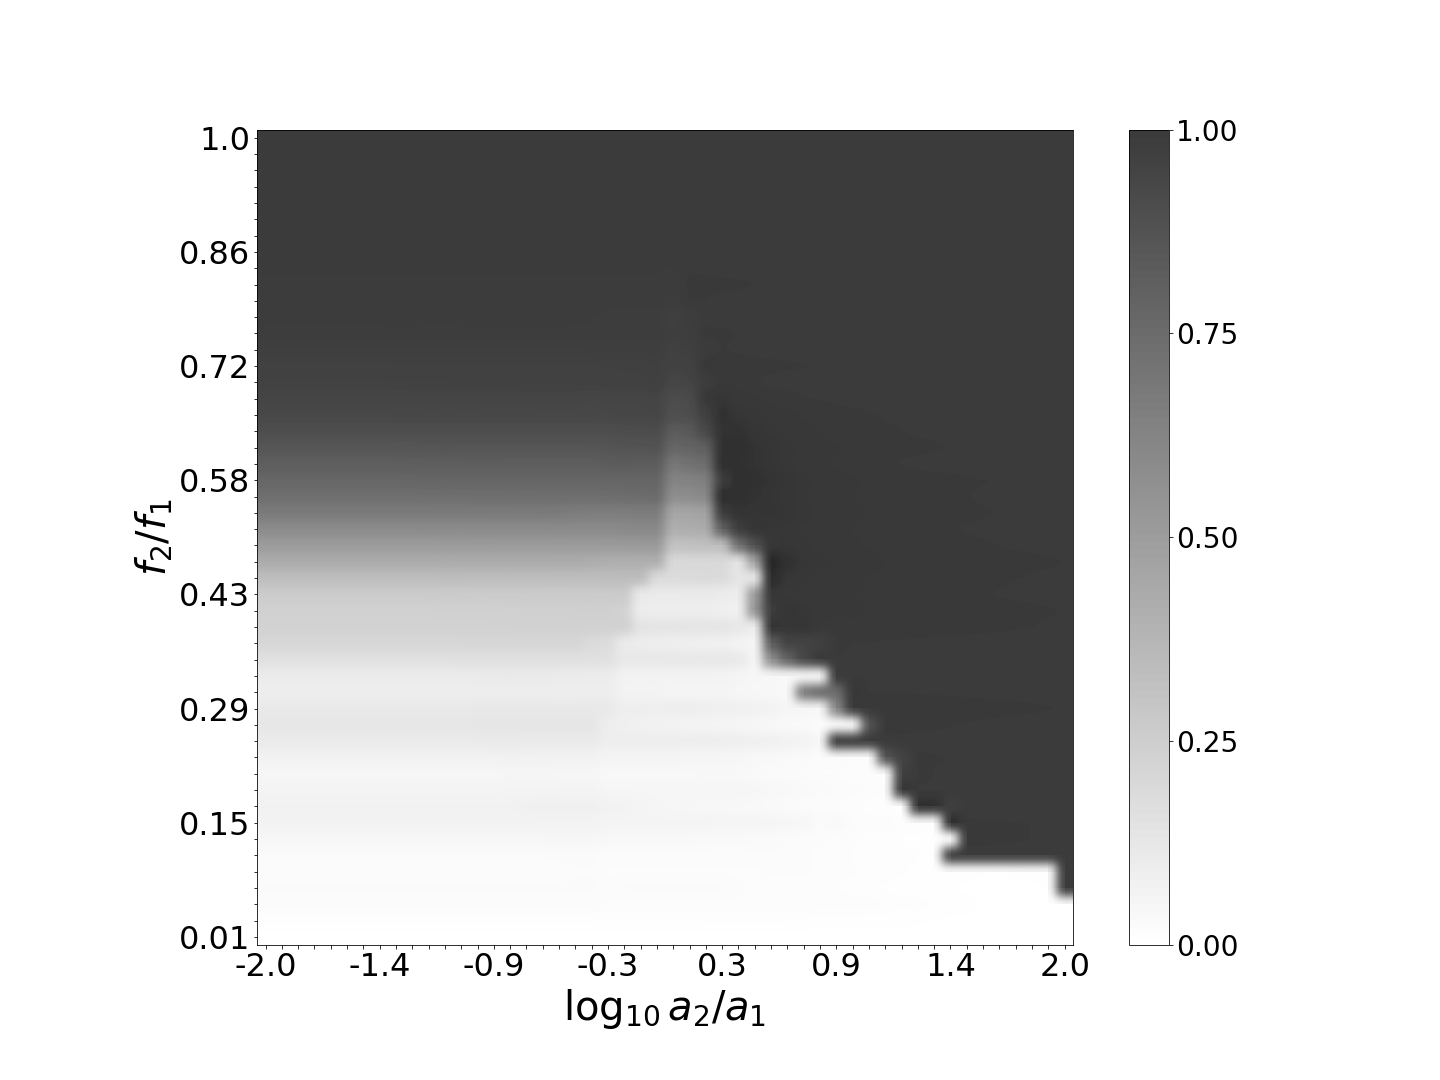

In [125]:
fig, ax = plt.subplots(figsize=(20,15))

plt.imshow(E_all, origin='lower', cmap='gray_r', interpolation='hamming', vmin=0., vmax=1.3)
plt.xlabel('$\log_{10} \, a_2/a_1$', fontsize=40)
plt.ylabel('$f_2/f_1$', fontsize=40)
plt.xticks(np.linspace(0,n_amp_steps,n_amp_steps+1), np.round(np.log10(a_r), 1), fontsize=32)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(f_r, 2), fontsize=32)
plt.xlim(-0.5, n_amp_steps-0.5)
plt.ylim(-0.5, n_freq_steps-0.5)
cbar = plt.colorbar(ticks=np.linspace(0,1,5), boundaries=np.linspace(0,1,100), values=np.linspace(0,1,99))
cbar.ax.tick_params(labelsize=28)

every_nth = 7
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
        
# save figure
plt.savefig('plots/ch4-1-4_2d_plot_amp_freq.pdf', bbox_inches = "tight")

plt.show()

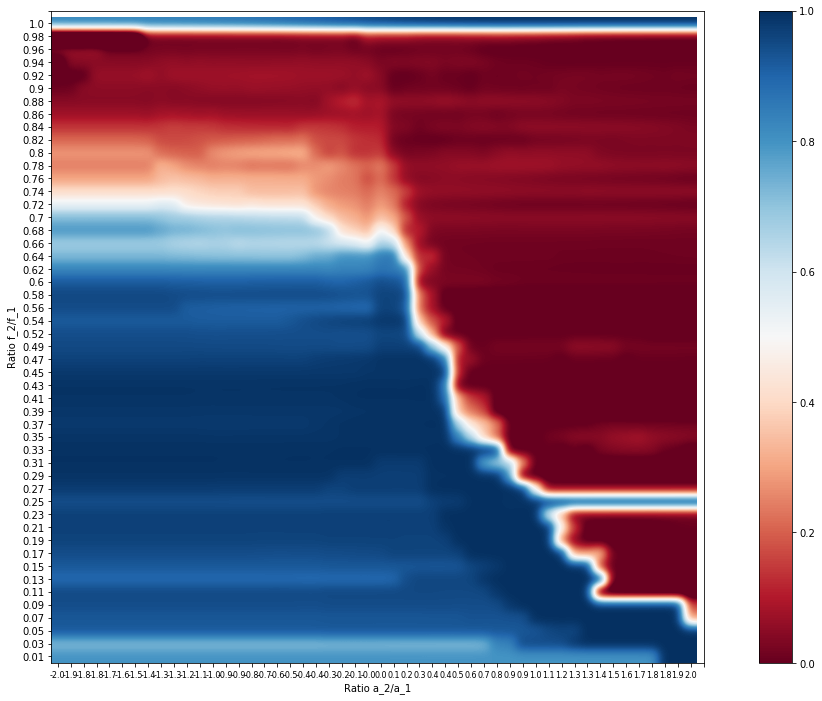

In [14]:
plt.figure(figsize=(20,12))
plt.imshow(C_all[:,:,1,1], origin='lower', cmap='RdBu', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('Ratio a_2/a_1')
plt.ylabel('Ratio f_2/f_1')
plt.xticks(np.linspace(0,n_amp_steps,n_amp_steps+1), np.round(np.log10(a_r), 1), fontsize=8)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(f_r, 2))
plt.colorbar()
plt.show()

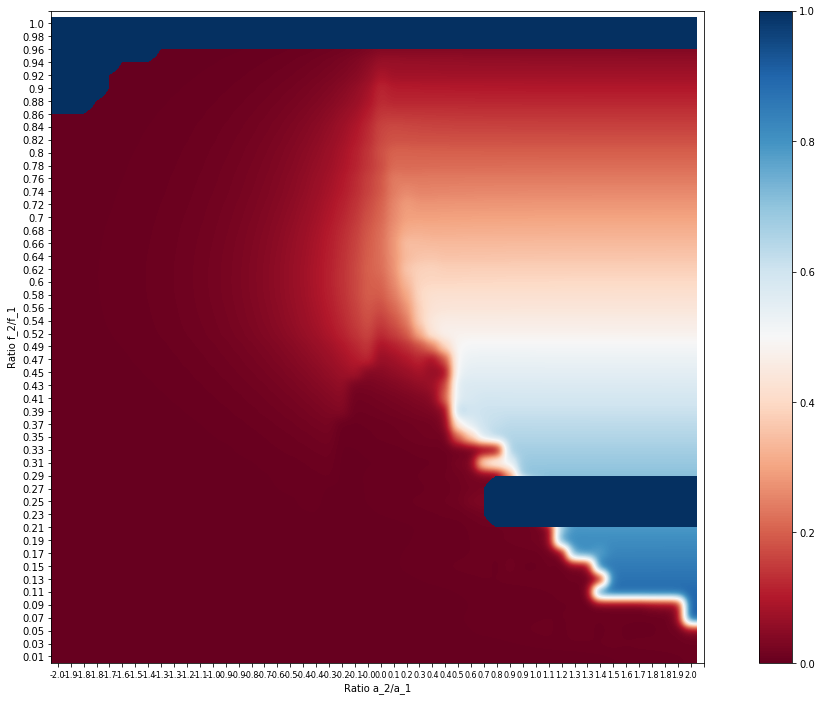

In [13]:
plt.figure(figsize=(20,12))
plt.imshow(IF_nb_all[:,:,0], origin='lower', cmap='RdBu', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('Ratio a_2/a_1')
plt.ylabel('Ratio f_2/f_1')
plt.xticks(np.linspace(0,n_amp_steps,n_amp_steps+1), np.round(np.log10(a_r), 1), fontsize=8)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(f_r, 2))
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(20,12))
plt.imshow(IA_all[:,:,1], origin='lower', cmap='RdBu', interpolation='gaussian', vmin=0., vmax=1.)
plt.xlabel('Ratio a_2/a_1')
plt.ylabel('Ratio f_2/f_1')
plt.xticks(np.linspace(0,n_amp_steps,n_amp_steps+1), np.round(np.log10(a_r), 1), fontsize=8)
plt.yticks(np.linspace(0,n_freq_steps,n_freq_steps+1), np.round(f_r, 2))
plt.colorbar()
plt.show()

In [ ]:
plt.plot(instantaneous_frequency.T)
plt.plot(8*np.ones(shape=(6000,)))
plt.plot(F[0][1]*np.ones(shape=(6000,)))
plt.ylim(0,40)
plt.show()

In [ ]:
plt.subplot(211)
plt.plot(imfs[0,:])
plt.subplot(212)
plt.plot(imfs[1,:])
plt.show()

### Compute concentration of correlation matrix on diagonal

In [ ]:
diag_conc = np.zeros((n_freq_steps, n_sample_rates, n_lengths))
for k in range(n_freq_steps):
    for j in range(n_sample_rates):
        for i in range(n_lengths):
            sum_diag = np.sum(np.abs(np.diag(np.fliplr(C_all[k,j,i,:,:]))))
            sum_off_diag = np.sum(C_all[k,j,i,:,:]) - sum_diag
            diag_conc[k,j,i] = sum_diag/(sum_diag + sum_off_diag)

In [ ]:
# C_all[n_freq_steps, n_sample_rates, n_lengths, nF, nF]

plt.figure(figsize=(12,12))
plt.imshow(diag_conc[:,-1,:], origin='lower', cmap='gray', vmin=0., vmax=1.)
#plt.xlabel('Signal Lengths')
#plt.ylabel('Sample Rates')
#plt.yticks(np.linspace(0,100,101), np.round(f_1*ratios, 2))
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(sig_lengths, diag_conc[0,-2,:], '--o')
plt.xlim(0, max_length)
xcoords = np.round(np.linspace(cycle_length, max_length, int(max_length/cycle_length)), 2)
plt.xticks(xcoords, np.arange(1,len(xcoords)+1))
for xc in xcoords:
    plt.axvline(x=xc, linestyle='dotted', color='grey')
plt.xlabel('Number of cycles')
plt.ylabel('Concentration on diagonal')
plt.show()

In [ ]:
#IF_all[f_i, fs_i, s_i, :]

plt.figure(figsize=(20,20))
plt.imshow(IF_all[:,:,-1,1], origin='lower', cmap='gray', vmin=0., vmax=1.)
plt.colorbar()
plt.show()

In [ ]:
#IF_all[f_i, fs_i, s_i, :]

plt.figure(figsize=(20,20))
plt.imshow(IA_nb_all[:,:,-1,0], origin='lower', cmap='gray', vmin=0., vmax=0.005*max_amp)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(C_all[0,0,:,:])
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.title('Signal Length: ' + str(sig_lengths[0]) + ' seconds')
plt.xlabel('components')
plt.ylabel('imfs')
plt.subplot(212)
plt.imshow(C_all[-1,-1,:,:])
plt.colorbar()
plt.clim(-0.2, 1.0)
plt.title('Signal Length: ' + str(sig_lengths[n_lengths-1]) + ' seconds')
plt.xlabel('components')
plt.ylabel('imfs')
plt.show()

### Print median frequencies of IMFs

In [ ]:
np.set_printoptions(suppress=True)
f_m = np.round(np.median(instantaneous_frequency,1),2)
for i in range(len(f_m)):
    print('IMF ' + str(i+1) + ': ' + str(f_m[i]))

### Plot data and IMFs

In [ ]:
plt.figure(figsize=(30,50))
plt.subplot(nIMF+1,1,1)
plt.plot(x, linewidth=3)
plt.xlim(0, fs)
plt.title('Data', fontsize=20)
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(imfs[ii-1,:], linewidth=3)
    #plt.plot(C[-ii,:], '--k',linewidth=2)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz, '
             )#'Actual: ' + str(f[-ii]), fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Signal Strength', fontsize=20)
    plt.xlim(0, fs)
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.sum(imfs[(f_m > 5.) & (f_m < 12.),:], axis=0))
plt.plot(C[0,:], '--k')
plt.xlim(0, fs)
plt.show()

### Plot instantaneous frequency of IMFS

In [ ]:
plt.figure(figsize=(30,40))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(instantaneous_frequency[ii-1,:], linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    #plt.xlim(0, fs)
plt.show()

In [ ]:
plt.figure(figsize=(30,40))
for ii in range(1,nIMF+1):
    plt.subplot(nIMF+1,1,ii+1)
    plt.plot(instantaneous_frequency[ii-1,int(nT/20):int(-nT/20)], linewidth=3)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Intrinsic mode function ' + str(ii) + ': ' + str(f_m[ii-1]) + 'Hz', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Frequency (Hz)', fontsize=20)
    #plt.xlim(0, fs)
plt.show()

In [ ]:
np.std(instantaneous_frequency[(f_m > 5.) & (f_m < 12.), :], axis=1)

In [ ]:
np.std(instantaneous_frequency, axis=1)

In [ ]:
np.std(instantaneous_frequency[:, int(nT/20):int(-nT/20)], axis=1)

### Plot data components

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for j in range(nF):
    plt.plot(t, C[j,:], label=str(f[j]))

plt.plot(t, noise)
#plt.axis((0, 0.2, -1.5, 1.5))
plt.legend()
plt.subplot(2,1,2)
plt.plot(t,x)
plt.show()